# Additional experiments

## topology weights

In [1]:
SINGLENODE_WEIGHTS = './@g513_0214_2_best/*[19999]0.004812348634004593_last.h5'
TOPOLOGY_WEIGHTS = './@g513_0214_2_best/@[10835]0.002623665379360318.h5'

In [2]:
import sys
sys.path.append('/Users/jihye/src/Ryu project/TSN-with-DQN/ddqn')

import pandas as pd
import simpy
# from node import Node 
import time
import tensorflow as tf
# from parameter import *
# from src import Src

## Copy classes(Node(),Src()) manualy instead of importing due to Global parameter

In [3]:

class Node:

    def __init__(self, node, env, start):
        self.node = node
        self.env = env
        self.start = start
        self.output_port = [[simpy.Store(env), simpy.Store(env)] for _ in range(OUTPUT_PORT)]
        # self.trans_queue = simpy.Store(env)
        self.action = [number_to_action(INITIAL_ACTION) for _ in range(OUTPUT_PORT)]
        self.port = -1
        self.r = [0, 0]
        self.rr = 0
        self.state = [np.zeros(INPUT_SIZE) for _ in range(OUTPUT_PORT)]

    def reset(self, env, start):  # initial state, new episode start
        self.env = env
        self.start = start
        self.r = [0, 0]
        self.rr = 0
        self.output_port = [[simpy.Store(env), simpy.Store(env)] for _ in range(OUTPUT_PORT)]
        self.action = [number_to_action(INITIAL_ACTION) for _ in range(OUTPUT_PORT)]
        self.state = [np.zeros(INPUT_SIZE) for _ in range(OUTPUT_PORT)]
        self.port = -1

    def schedulable(self):
        port = []

        for p in range(OUTPUT_PORT):
            q1 = int(self.state[p][0])
            q2 = int(self.state[p][2])
            # print (q1, q2)
            if not (q1 + q2 == (q1 or q2)):
                port.append(p)

        return port

    def link(self, output, scheduler='sp'):
        if scheduler == 'ddqn':
            for p in range(OUTPUT_PORT):
                yield self.env.process(self.ddqn_with_heuristic(output, p))
        elif scheduler == 'sp':
            for p in range(OUTPUT_PORT):
                yield self.env.process(self.strict_priority(output, p))
        elif scheduler == 'rr':
            for p in range(OUTPUT_PORT):
                yield self.env.process(self.round_robin(output, p))
        else:
            for p in range(OUTPUT_PORT):
                yield self.env.process(self.ddqn(output, p))

    def packet_in(self, pk):
        pt = 0
        if OUTPUT_PORT == 2:
            if self.port == -1:
                if pk.route_[1]:
                    self.port = pk.route_[1]
                else:
                    self.port = 0
            else:
                if self.port:
                    if not (pk.route_[1] == self.port):
                        pt = 1
        yield self.output_port[pt][pk.priority_ - 1].put(pk)

    def step(self):

        for p in range(OUTPUT_PORT):
            qlen, max_et = self.queue_info(p)
            state = np.zeros((PRIORITY_QUEUE, STATE))
            state[:, 0] = qlen
            state[:, 1] = max_et
            self.state[p] = state.flatten()

        return self.state

    def queue_info(self, port):
        l = [0, 0]  # state 1
        pod = [[], []]
        max_et = [0, 0]  # state 2
        for q in range(PRIORITY_QUEUE):
            flows = self.output_port[port][q].items
            if not flows:
                continue
            l[q] += len(flows)
            for i, flow in enumerate(flows):
                # The unit of estimated delay is T(timeslot)
                if SINGLE_NODE:
                    # et = flow.current_delay_ + flow.queueing_delay_ + flow.remain_hops_ + i
                    et = (flow.random_delay_ + flow.current_delay_ + flow.queueing_delay_ + flow.remain_hops_ + i)
                else:
                    # et = sum(flow.queueing_delay_) + flow.remain_hops_ + i
                    et = (flow.random_delay_ + sum(flow.queueing_delay_) + flow.remain_hops_ + i)
                pod_ = round(et/flow.deadline_,2)
                pod[q].append(pod_)
            max_et[q] = max(pod[q])
        return l, max_et

    def action_update(self, action, port):  # observe state and update GCL (cycle : 0.2*3)
        self.action[port] = number_to_action(action)

    def delay_for_packet_multinode(self, port):
        for q in range(PRIORITY_QUEUE):
            waiting = self.output_port[port][q].items
            for w in waiting:
                r = w.remain_hops_
                l = len(w.queueing_delay_)
                w.queueing_delay_[l - r - 1] += 1

    def delay_for_packet(self, port):
        for q in range(PRIORITY_QUEUE):
            waiting = self.output_port[port][q].items
            for w in waiting:
                w.queueing_delay_ += 1

    def ddqn_with_heuristic(self, output, port):

        priority1 = self.output_port[port][0].items
        priority2 = self.output_port[port][1].items

        if not priority1:
            # print("priority1 없음 - work conserving")
            if len(self.output_port[port][1].items):
                # print("priority2 보냄")
                fl = yield self.output_port[port][1].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                # if (port == 0) and (self.node == 2):
                #     print((self.env.now- self.start), "H - p2", fl.generated_time_, fl.queueing_delay_, fl.current_delay_)
                yield output.put(fl)

        elif not priority2:
            if len(self.output_port[port][0].items):
                fl = yield self.output_port[port][0].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                # if (port == 0) and (self.node == 2):
                #     print((self.env.now- self.start), "H - p1", fl.generated_time_, fl.queueing_delay_, fl.current_delay_)
                yield output.put(fl)
        else:
            if action_to_number(self.action[port]) == 0:
                # if len(self.output_port[port][0].items):
                fl = yield self.output_port[port][0].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                # if (port == 0) and (self.node == 2):
                #     print((self.env.now- self.start), "Q - p1", fl.generated_time_, fl.queueing_delay_, fl.current_delay_)
                yield output.put(fl)

            else:
                # if len(self.output_port[port][1].items):
                fl = yield self.output_port[port][1].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                # if (port == 0) and (self.node == 2):
                #     print((self.env.now- self.start), "Q - p2", fl.generated_time_, fl.queueing_delay_, fl.current_delay_)
                yield output.put(fl)

        if SINGLE_NODE:
            self.delay_for_packet(port)
        else:
            self.delay_for_packet_multinode(port)

    def ddqn(self, output, port):

        if action_to_number(self.action[port]) == 0:
            if len(self.output_port[port][0].items):
                fl = yield self.output_port[port][0].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)

        else:
            if len(self.output_port[port][1].items):
                fl = yield self.output_port[port][1].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)

        if SINGLE_NODE:
            self.delay_for_packet(port)
        else:
            self.delay_for_packet_multinode(port)

    def round_robin(self, output, port):
        
        priority1 = self.output_port[port][0].items
        priority2 = self.output_port[port][1].items

        # n = [1, 0]
        if not priority1: #work-conserving regardless of weight
            if len(self.output_port[port][1].items):
                fl = yield self.output_port[port][1].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)

        elif not priority2: #work-conserving regardless of weight
            if len(self.output_port[port][0].items):
                fl = yield self.output_port[port][0].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)
                
        else: #scheduling
            if self.r[1] == 1:
                fl = yield self.output_port[port][1].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                self.r = [0, 0]
                yield output.put(fl)
            
            elif self.r[0] < RRW:
                fl = yield self.output_port[port][0].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)
                if self.r[0] == RRW - 1:
                    self.r[1] = 1
                else:
                    self.r[0] += 1

#         for q in range(PRIORITY_QUEUE):
# #             print(self.r)
#             if self.r[1] == 1:
#                 if len(self.output_port[port][1].items):
#                     fl = yield self.output_port[port][1].get()
#                     fl.remain_hops_ -= 1
#                     fl.route_ = fl.route_[1:]
#                     yield output.put(fl)
#                     self.r = [0, 0]
#                     # print(self.r)
#                     break
#                 elif len(self.output_port[port][0].items):
#                     fl = yield self.output_port[port][0].get()
#                     fl.remain_hops_ -= 1
#                     fl.route_ = fl.route_[1:]
#                     yield output.put(fl)
#                     # self.r = [0, 0]
#                     # print(self.r)
#                     break
#             if self.r[0] <= RRW:
#                 if len(self.output_port[port][q].items):
#                     # print(self.output_port[port][q].items)
#                     # print(self.r)
#                     fl = yield self.output_port[port][q].get()
#                     fl.remain_hops_ -= 1
#                     fl.route_ = fl.route_[1:]
#                     yield output.put(fl)
#                     if self.r[0] == RRW:
#                         self.r[1] = 1
#                     else:
#                         self.r[0] += 1
#                     break

        if SINGLE_NODE:
            self.delay_for_packet(port)
        else:
            self.delay_for_packet_multinode(port)

    def strict_priority(self, output, port):

        for q in range(PRIORITY_QUEUE):
            if len(self.output_port[port][q].items):
                fl = yield self.output_port[port][q].get()
                fl.remain_hops_ -= 1
                fl.route_ = fl.route_[1:]
                yield output.put(fl)
                break

        if SINGLE_NODE:
            self.delay_for_packet(port)
        else:
            self.delay_for_packet_multinode(port)


In [4]:

class Src:
    def __init__(self, src, start_time, seq):
        self.src = src
        self.cnt = 0
        self.episode_start_time = start_time
        self.sequence_p1, self.sequence_p2 = seq

    def reset(self, src, start_time):
        self.src = src
        self.cnt = 0
        self.episode_start_time = start_time

    def flow_generator(self, now, src, fnum):
        flow = Flow()

        flow.priority_ = 1

        if 1 < src < 8:  # must got to be editted when network topology being changed
            flow.priority_ = 2

        flow.src_ = src
        flow.dst_ = src
        flow.num_ = fnum
        flow.generated_time_ = now - self.episode_start_time
        flow.current_delay_ = 0
        flow.met_ = -1

        if SINGLE_NODE:
            flow.route_ = []
            flow.queueing_delay_ = 0

            if flow.priority_ == 1:
                flow.remain_hops_ = self.sequence_p1[1][fnum]
                flow.random_delay_ = self.sequence_p1[0][fnum]
                flow.deadline_ = CC_DEADLINE
                flow.bits_ = CC_BYTE * 8
            else:
                flow.remain_hops_ = self.sequence_p2[1][fnum]
                flow.random_delay_ = self.sequence_p2[0][fnum]
                flow.deadline_ = BE_DEADLINE
                flow.bits_ = BE_BYTE * 8

        else:
            flow.route_ = route[src - 1]
            h = len(route[src - 1]) - 1
            flow.remain_hops_ = h - 1
            flow.queueing_delay_ = [0 for _ in range(h)]  # nodes to be passed packts

            if flow.priority_ == 1:
                flow.deadline_ = CC_DEADLINE
                flow.random_delay_ = self.sequence_p1[0][fnum]
                flow.bits_ = CC_BYTE * 8

            else:
                flow.deadline_ = BE_DEADLINE
                flow.random_delay_ = self.sequence_p2[0][fnum]
                flow.bits_ = BE_BYTE * 8

        return flow

    def send(self, env, nodes, src):
        if SINGLE_NODE:
            if not 1 < src < 8:  # must got to be editted when network topology being changed
                for i in range(COMMAND_CONTROL):
                    flow = self.flow_generator(env.now, src, i)
                    yield env.process(nodes.packet_in(flow))
                    yield env.timeout(TIMESLOT_SIZE * PERIOD_CC / 1000)

            else:
                for i in range(BEST_EFFORT):
                    flow = self.flow_generator(env.now, src, i)
                    yield env.process(nodes.packet_in(flow))
                    yield env.timeout(TIMESLOT_SIZE * PERIOD_BE / 1000)
        else:
            if not 1 < src < 8:  # must got to be editted when network topology being changed
                for i in range(COMMAND_CONTROL):
                    flow = self.flow_generator(env.now, src, i)
                    r = flow.route_[0]
                    yield env.process(nodes[r - 1].packet_in(flow))
                    yield env.timeout(TIMESLOT_SIZE * PERIOD_CC / 1000)

            else:
                for i in range(BEST_EFFORT):
                    flow = self.flow_generator(env.now, src, i)
                    r = flow.route_[0]
                    yield env.process(nodes[r - 1].packet_in(flow))
                    yield env.timeout(TIMESLOT_SIZE * PERIOD_BE / 1000)


In [5]:
class Node_Old(Node):
    def __init__(self,node,env,start):
        super().__init__(node,env,start)
        
    def queue_info(self, port):
        l = [0, 0]  # state 1
        pod = [[], []]
        max_et = [0, 0]  # state 2
        for q in range(PRIORITY_QUEUE):
            flows = self.output_port[port][q].items
            if not flows:
                continue
            l[q] += len(flows)
            for i, flow in enumerate(flows):
                # The unit of estimated delay is T(timeslot)
                if SINGLE_NODE:
                    # et = flow.current_delay_ + flow.queueing_delay_ + flow.remain_hops_ + i
                    et = (flow.random_delay_ + flow.current_delay_ + flow.queueing_delay_ + flow.remain_hops_ + i)
                else:
                    # et = sum(flow.queueing_delay_) + flow.remain_hops_ + i
                    et = (flow.random_delay_ + sum(flow.queueing_delay_) + flow.remain_hops_ + i)
#                 pod_ = round(et/flow.deadline_,2)
                pod[q].append(et)
            max_et[q] = max(pod[q])
        return l, max_et
        

### SINGLE NODE

In [84]:
# def operator(delay):
#     delay = np.mean(delay * 3192478)
#     return delay

class GateControlTestSimulation:

    def __init__(self):
        self.end_time = 0
        self.model = tf.keras.models.load_model(WEIGHT_FILE)
        self.env = simpy.Environment()
        self.start_time = self.env.now
        # self.sequence_p1, self.sequence_p2 = random_sequence()
        self.seq = random_sequence()
        self.source = Src(1, self.start_time, self.seq)
        self.node = Node_Old(1, self.env, self.start_time)
        self.trans_list = simpy.Store(self.env)
        self.cnt1 = 0
        self.cnt4 = 0
        self.timeslots = 0  # progressed timeslots in a episode
        state_shape = [np.zeros(INPUT_SIZE) for _ in range(OUTPUT_PORT)]
        self.state = state_shape
        self.next_state = state_shape
        self.reward = 0
        self.done = False
        self.received_packet = 0  
        # save logs
#         self.ex = pd.DataFrame(columns=['timeslot', 'state', 'gcl'])
#         self.ap = pd.DataFrame(columns=['timeslot', 'state', 'gcl'])

        self.log1 = pd.DataFrame(
            columns=['Slots', 'Score', 'p1', 'p2'])  # extract
        self.log2 = pd.DataFrame(
            columns=['Slots', 'Score', 'p1', 'p2'])  # sp
        self.log3 = pd.DataFrame(
            columns=['Slots','Score','p1','p2']) #rr
        
        self.success = [0, 0]  # deadline met
        self.etdelay = [[],[]]
        self.qdelay=[[],[]]
        
        self.score = 0
#         self.sp_score = 0
#         self.ddqn_score = 0
        

    def reset(self):  # initial state, new episode start
        self.start_time = self.env.now  # episode 시작
        self.node = Node_Old(1, self.env, self.start_time)
        self.source = Src(1, self.start_time, self.seq)
        self.trans_list = simpy.Store(self.env)
        self.timeslots = 0
        self.cnt1 = 0
        self.cnt4 = 0
        state_shape = [np.zeros(INPUT_SIZE) for _ in range(OUTPUT_PORT)]
        self.state = state_shape
        self.next_state = state_shape
        self.reward = 0
        self.done = False

        self.received_packet = 0
        self.success = [0, 0]  # deadline met
        self.etdelay = [[],[]]
        self.qdelay=[[],[]]
        
        # self.et = []
        # self.delay = pd.DataFrame(columns=['p1', 'p2'])
#         self.ex = pd.DataFrame(columns=['timeslot', 'state', 'gcl'])
#         self.ap = pd.DataFrame(columns=['timeslot', 'state', 'gcl'])
        
        self.score = 0
#         self.sp_score = 0
#         self.ddqn_score = 0

    def ddqn_predict(self, state):
        n = self.model.predict(state)
        id_ = np.argmax(n)
        # action = number_to_action(id_)
        print(n,id_)
        return id_

    def reward_func(self, packet):
        r = 0
        p = packet.priority_ - 1
        packet.current_delay_ += packet.queueing_delay_
        et = packet.random_delay_ + packet.current_delay_ + packet.remain_hops_ + 1
        
        packet.queueing_delay_ = 0
        packet.arrival_time_ = self.env.now - self.start_time
        self.etdelay[p].append(et) # realtime latency
        self.qdelay[p].append(packet.current_delay_) #qdlay
        

        dl = packet.deadline_
#         print(dl, et)

        if COMPLEX:
            if BOUND[p] <= et / dl <= 1:  # packet received within configured latency boundary
                packet.met_ = 1
                self.success[p] += 1
                r += W0[p]
                # self.reward += W[t]

            elif et / dl < BOUND[p]:
                packet.met_ = 1
                self.success[p] += 1
                r += 0.01

            elif 1 < et / dl <= LM:
                packet.met_ = 0
                r += W2[p]

            else:
                packet.met_ = 0
                r -= et / dl
        else:
            if et / dl <= 1:
                packet.met_ = 1
                self.success[p] += 1
                r += W[p] + A
            else:
                packet.met_ = 0
                r += A
        return r

    def sendTo_next_node(self, env):
        flows = self.trans_list

        if not (len(flows.items)):
            return

        # transmission completed immediatly
        for _ in range(len(flows.items)):
            flow = yield flows.get()
            self.received_packet += 1

            self.reward += self.reward_func(flow)


    def rl_agent(self, env):  # mainprocess
        rewards_all = []
        action = [INITIAL_ACTION for _ in range(OUTPUT_PORT)]

        env.process(self.source.send(env, self.node, 1))
        env.process(self.source.send(env, self.node, 4))

        while not self.done:
            self.timeslots += 1
#             log = pd.DataFrame([(self.timeslots, self.state, action)], columns=['timeslot', 'state', 'gcl'])
            yield env.process(self.node.link(self.trans_list, 'ddqn'))
            yield env.process(self.sendTo_next_node(env))
            yield env.timeout(TIMESLOT_SIZE * 0.001)

            
            self.next_state = self.node.step()
            self.done = self.terminated()
            rewards_all.append(self.reward)
            self.reward = 0
            self.state = self.next_state

            # observe(생략)

            p = self.node.schedulable()
            for i in p:
                action[i],_ = self.ddqn_predict(
                    np.array(self.state[i]).reshape(1, INPUT_SIZE))
                self.node.action_update(action[i], i)

            # self.ex = self.ex.append(log, ignore_index=True)

        # Episode ends
        self.end_time = env.now
        self.score = np.sum(rewards_all)
        log_ = pd.DataFrame([(self.timeslots, np.sum(rewards_all), self.success[0], self.success[1])],
                            columns=['Slots', 'Score', 'p1', 'p2'])

        self.log1 = self.log1.append(log_, ignore_index=True)


    def SP(self, env):
        rewards_all = []
        env.process(self.source.send(env, self.node, 1))
        env.process(self.source.send(env, self.node, 4))

        while not self.done:
            self.timeslots += 1
            yield env.process(self.node.link(self.trans_list, 'sp'))
            yield env.process(self.sendTo_next_node(env))
            yield env.timeout(TIMESLOT_SIZE * 0.001)

            self.next_state = self.node.step()
            self.done = self.terminated()
            rewards_all.append(self.reward)
            self.reward = 0
            self.state = self.next_state
            
        self.score = np.sum(rewards_all)
        log_ = pd.DataFrame([(self.timeslots, np.sum(rewards_all), self.success[0], self.success[1])],
                            columns=['Slots', 'Score', 'p1', 'p2'])

        self.log2 = self.log2.append(log_, ignore_index=True)
        
    def RR(self, env):
        rewards_all = []
        env.process(self.source.send(env, self.node, 1))
        env.process(self.source.send(env, self.node, 4))

        while not self.done:
            self.timeslots += 1
            yield env.process(self.node.link(self.trans_list, 'rr'))
            yield env.process(self.sendTo_next_node(env))
            yield env.timeout(TIMESLOT_SIZE * 0.001)

            self.next_state = self.node.step()
            self.done = self.terminated()
            rewards_all.append(self.reward)
            self.reward = 0
            self.state = self.next_state
            
        self.score = np.sum(rewards_all)
        log_ = pd.DataFrame([(self.timeslots, np.sum(rewards_all), self.success[0], self.success[1])],
                            columns=['Slots', 'Score', 'p1', 'p2'])
        self.log3 = self.log2.append(log_, ignore_index=True)



    def model_simulation(self, i, model='ddqn'):
        if model == 'ddqn':
            self.env.process(self.rl_agent(self.env))
            self.env.run()
            D1 = np.array([self.qdelay[0], self.etdelay[0]]).T
            D2 = np.array([self.qdelay[1], self.etdelay[1]]).T
            d1 = pd.DataFrame(D1, columns = ['qdelay','et'])
            d2 = pd.DataFrame(D2, columns = ['qdelay','et'])
#             d1.to_csv('./test/single_delay1.csv')
#             d2.to_csv('./test/single_delay2.csv')
            if i > 0:
#                 self.ddqn_score = self.success
                print("DDQN+H , Final Step: {t}, success: {l}, avg_qdelay: {d}".format(
                    t=self.timeslots,
                    l=self.success,
                    d=list(map(np.mean, self.qdelay))))
                print("qdelay?",self.qdelay)

        elif model == 'sp':
            self.env.process(self.SP(self.env))
            self.env.run()
            D1 = np.array([self.qdelay[0], self.etdelay[0]]).T
            D2 = np.array([self.qdelay[1], self.etdelay[1]]).T
            d1 = pd.DataFrame(D1, columns = ['qdelay','et'])
            d2 = pd.DataFrame(D2, columns = ['qdelay','et'])
#             d1.to_csv('./test/SP/single_delay1.csv')
#             d2.to_csv('./test/SP/single_delay2.csv')

            if i > 0:
#                 self.sp_score = self.success
                print("SP , Final Step: {t}, success: {l}, avg_qdelay: {d}".format(
                    t=self.timeslots,
                    l=self.success,
                    d=list(map(np.mean, self.qdelay))))
                print("qdelay?",self.qdelay)
    
        elif model == 'rr':
            self.env.process(self.RR(self.env))
            self.env.run()
            D1 = np.array([self.qdelay[0], self.etdelay[0]]).T
            D2 = np.array([self.qdelay[1], self.etdelay[1]]).T
            d1 = pd.DataFrame(D1, columns = ['qdelay','et'])
            d2 = pd.DataFrame(D2, columns = ['qdelay','et'])
#             d1.to_csv('./test/RR/single_delay1.csv')
#             d2.to_csv('./test/RR/single_delay2.csv')

            if i > 0:
#                 self.sp_score = self.success
                print("RR , Final Step: {t}, success: {l}, avg_qdelay: {d}".format(
                    t=self.timeslots,
                    l=self.success,
                    d=list(map(np.mean, self.qdelay))))
                print("qdelay?",self.qdelay)

        elif model == 'reset':
            print("reset")
            self.seq = random_sequence()
            self.source = Src(1, self.start_time, self.seq)

    def simulation(self):
        iteration = 2
        s1=0
        s2=0
        for i in range(iteration):
            self.model_simulation(i, 'sp')
#             if i>0:
#                 s1 = self.score
#                 s1s = self.success
            self.reset()

            self.model_simulation(i, 'ddqn')
#             if i>0:
#                 s2 = self.score
#                 s2s = self.success
                
            self.reset()
            
            self.model_simulation(i, 'rr')
            self.reset()
        

#             if s2 > s1:
#                 return [s1,s1s, s2,s2s]
            
#             self.model_simulation(i, 'reset')
            
        
#         self.log1.to_csv('./test/single_ddqn.csv')
#         self.log2.to_csv('./test/SP/single_sp.csv')
#         self.log3.to_csv('./test/RR/single_rr.csv')

#         return 'X'

    def terminated(self):
        done = False

        if MAXSLOT_MODE:
            if (self.received_packet == COMMAND_CONTROL + BEST_EFFORT) or (self.timeslots == MAXSLOTS):
                done = True
        else:
            if self.received_packet == COMMAND_CONTROL + BEST_EFFORT:  # originally (CC + A + V + BE)
                done = True

        return done

### TOPOLOGY

In [90]:

def operator(delay):
    delay = np.mean(delay * 1000)
    return delay


class GateControlTestSimulation():

    def __init__(self):
        self.model = tf.keras.models.load_model(WEIGHT_FILE)
        self.env = simpy.Environment()
        self.start_time = self.env.now
        self.nodes = [Node_Old(n + 1, self.env, self.start_time) for n in range(NODES)]
        self.output = {1: simpy.Store(self.env),
                       2: simpy.Store(self.env),
                       3: simpy.Store(self.env),
                       4: simpy.Store(self.env),
                       5: simpy.Store(self.env),
                       6: simpy.Store(self.env),
                       7: simpy.Store(self.env),
                       8: simpy.Store(self.env),
                       9: simpy.Store(self.env)}
        self.seq = random_sequence()
        self.source = Src(1, self.start_time, self.seq)
        self.timeslots = 0
        state_shape = [np.zeros(INPUT_SIZE) for _ in range(OUTPUT_PORT)]
        self.state = [state_shape for _ in range(NODES)]
        self.reward = [0 for _ in range(NODES)]
        self.next_state = [state_shape for _ in range(NODES)]
        self.done = False
        self.end_time = 0
        self.received_packet = 0
        self.score = 0

        self.avg_delay = [[], []]
        self.estimated_e2e = [[], []]
        self.success = [0 for _ in range(SRCES)]
        self.scenario = pd.DataFrame(columns = ['type','Score','p1','p2'])

        # self.state_and_action = []

    def reset(self):  # initial state, new episode start
#         self.env = simpy.Environment()
        self.start_time = self.env.now  # episode 시작
        self.nodes = [Node_Old(n + 1, self.env, self.start_time) for n in range(NODES)]
        self.source = Src(1, self.start_time, self.seq)
        self.timeslots = 0
        self.output = {1: simpy.Store(self.env),
                       2: simpy.Store(self.env),
                       3: simpy.Store(self.env),
                       4: simpy.Store(self.env),
                       5: simpy.Store(self.env),
                       6: simpy.Store(self.env),
                       7: simpy.Store(self.env),
                       8: simpy.Store(self.env),
                       9: simpy.Store(self.env)}
        state_shape = [np.zeros(INPUT_SIZE) for _ in range(OUTPUT_PORT)]
        self.state = [state_shape for _ in range(NODES)]
        self.next_state = [state_shape for _ in range(NODES)]
        self.reward = [0 for _ in range(NODES)]
        self.done = False
        self.end_time = 0
        self.received_packet = 0
        self.success = [0 for _ in range(SRCES)]
        self.avg_delay = [[], []]
        self.score = 0
        
    def ddqn_predict(self, state):
        n = self.model.predict(state)
        id_ = np.argmax(n)
        print(n,id_)
        # print (id_)
        # action = number_to_action(id_)
        return id_

    def sendTo_next_node(self, env, output):

        for i, pkts in output.items():
            if not len(pkts.items):
                continue
            for _ in range(len(pkts.items)):
                node = i - 1
                self.reward[node] += A
                packet = yield pkts.get()
                h = packet.remain_hops_
                l = len(packet.queueing_delay_)
                # print (h, l)
                q = packet.queueing_delay_[l - h - 2]
                packet.current_delay_ += q + 1

                p = packet.priority_ - 1
                src = packet.src_
                # print(packet.current_delay_)
                if packet.remain_hops_ < 0:
                    packet.remain_hops_ = 0
                # ET = packet.current_delay_ + packet.remain_hops
                ET = packet.current_delay_ + packet.remain_hops_ + packet.random_delay_
                
                if ET <= packet.deadline_:
                    self.reward[node] += W[p]
                    
                if packet.route_ == [0]:
                    self.received_packet += 1
                    
                    if node == 6 or node == 8:
                        # self.avg_delay[p].append(packet.queueing_delay_)
                        self.avg_delay[p].append(ET*TIMESLOT_SIZE)

                    if ET <= packet.deadline_:
                        packet.met_ = 1
#                         print(ET, self.received_packet)
                        # print (src - 1)
                        self.success[src - 1] += 1
                    else:
                        packet.met_ = 0
                else:
                    r = packet.route_[0]
                    yield env.process(self.nodes[r - 1].packet_in(packet))

    def src_send(self, env):
        if WITH_FLOW :
            env.process(self.source.send(env, self.nodes, 1))
            env.process(self.source.send(env, self.nodes, 2))
            env.process(self.source.send(env, self.nodes, 3))
            env.process(self.source.send(env, self.nodes, 4))
            env.process(self.source.send(env, self.nodes, 5))
            env.process(self.source.send(env, self.nodes, 6))
            env.process(self.source.send(env, self.nodes, 7))
            env.process(self.source.send(env, self.nodes, 8))
        
        else :
            env.process(self.source.send(env, self.nodes, 1))
            env.process(self.source.send(env, self.nodes, 2))
            env.process(self.source.send(env, self.nodes, 7))
            env.process(self.source.send(env, self.nodes, 8))

    def rl_agent(self, env):  # mainprocess
        s = time.time()
        rewards_all = []
        a = [INITIAL_ACTION for _ in range(OUTPUT_PORT)]
        action = [a for _ in range(NODES)]

        self.src_send(self.env)

        while not self.done:
            self.timeslots += 1

            for n in range(NODES):
                yield env.process(self.nodes[n].link(self.output[n + 1], 'ddqn'))
            yield env.process(self.sendTo_next_node(env, self.output))
            yield env.timeout(TIMESLOT_SIZE / 1000)

            for n in range(NODES):
                self.next_state[n] = self.nodes[n].step()
                self.done = self.terminated()
            rewards_all.extend(self.reward)
            self.reward = [0 for _ in range(NODES)]
            self.state = self.next_state

            # observe(생략)

            for n in range(NODES):
                p = self.nodes[n].schedulable()
                # p = [0, 1]
                for i in p:
                    # print("node:", n, self.state[n][i])
                    action[n][i],_ = self.ddqn_predict(
                        np.array(self.state[n][i]).reshape(1, INPUT_SIZE))
                    self.nodes[n].action_update(action[n][i], i)

        # Episode ends
        self.end_time = env.now
        e = time.time() - s
        self.score = np.sum(rewards_all)
        success1 = self.success[0]+self.success[7]
        success2 = np.sum(self.success[1:7])
        log_ = pd.DataFrame([('ddqn',self.score ,success1, success2)],columns = ['type','Score','p1','p2'])
        self.scenario = self.scenario.append(log_,ignore_index=True)

    def SP(self, env):
        s = time.time()
        rewards_all = []

        self.src_send(self.env)

        while not self.done:  # 1회의 episode가 종료될 때 까지 cycle을 반복하는 MAIN process
            self.timeslots += 1

            for n in range(NODES):
                yield env.process(self.nodes[n].link(self.output[n + 1], 'sp'))
#                 print(al)
            yield env.process(self.sendTo_next_node(env, self.output))
            yield env.timeout(TIMESLOT_SIZE / 1000)

            for n in range(NODES):
                # self.next_state[n] = self.nodes[n].step()
                self.done = self.terminated()
            rewards_all.extend(self.reward)
            self.reward = [0 for _ in range(NODES)]
            # self.state = self.next_state

        e = time.time() - s
        self.score = np.sum(rewards_all)
        success1 = self.success[0]+self.success[7]
        success2 = np.sum(self.success[1:7])
        log_ = pd.DataFrame([('sp',self.score ,success1, success2)],columns = ['type','Score','p1','p2'])
        self.scenario = self.scenario.append(log_,ignore_index=True)
        
    def RR(self, env):
        s = time.time()
        rewards_all = []

        self.src_send(self.env)

        while not self.done:  # 1회의 episode가 종료될 때 까지 cycle을 반복하는 MAIN process
            self.timeslots += 1

            for n in range(NODES):
                yield env.process(self.nodes[n].link(self.output[n + 1], 'rr'))
#                 print(al)
            yield env.process(self.sendTo_next_node(env, self.output))
            yield env.timeout(TIMESLOT_SIZE / 1000)

            for n in range(NODES):
                # self.next_state[n] = self.nodes[n].step()
                self.done = self.terminated()
            rewards_all.extend(self.reward)
            self.reward = [0 for _ in range(NODES)]
            # self.state = self.next_state

        e = time.time() - s
        self.score = np.sum(rewards_all)
        success1 = self.success[0]+self.success[7]
        success2 = np.sum(self.success[1:7])
        log_ = pd.DataFrame([('rr',self.score ,success1, success2)],columns = ['type','Score','p1','p2'])
        self.scenario = self.scenario.append(log_,ignore_index=True)

    def model_simulation(self, i, model='ddqn'):
        if model == 'ddqn':
            self.env.process(self.rl_agent(self.env))
            self.env.run()
            D1 = self.avg_delay[0]
            D2 = self.avg_delay[1]
            d1 = pd.DataFrame(D1)
            d2 = pd.DataFrame(D2)
            d1.to_csv('./test/delay1.csv')
            d2.to_csv('./test/delay2.csv')
            if i > 0:
                print("DDQN+H , Final Step: {t}, success: {l}, avg_qdelay: {d}".format(
                    t=self.timeslots,
                    l=self.success,
                    d=list(map(operator, self.avg_delay))))

        elif model == 'sp':
            self.env.process(self.SP(self.env))
            self.env.run()

            D1 = self.avg_delay[0]
            D2 = self.avg_delay[1]
            d1 = pd.DataFrame(D1)
            d2 = pd.DataFrame(D2)
            d1.to_csv('./test/SP/delay1.csv')
            d2.to_csv('./test/SP/delay2.csv')
            if i > 0:
                print("SP , Final Step: {t}, success: {l}, avg_qdelay: {d}".format(
                    t=self.timeslots,
                    l=self.success,
                    d=list(map(operator, self.avg_delay))))
#             self.reset()

        elif model == 'rr':
            self.env.process(self.RR(self.env))
            self.env.run()

            D1 = self.avg_delay[0]
            D2 = self.avg_delay[1]
            d1 = pd.DataFrame(D1)
            d2 = pd.DataFrame(D2)
            d1.to_csv('./test/RR/delay1.csv')
            d2.to_csv('./test/RR/delay2.csv')
            if i > 0:
                print("RR , Final Step: {t}, success: {l}, avg_qdelay: {d}".format(
                    t=self.timeslots,
                    l=self.success,
                    d=list(map(operator, self.avg_delay))))

        elif model == 'reset':
            print("reset")
            self.seq = random_sequence()
#             self.source = Src(1, self.start_time, self.seq)
            self.scenario= pd.DataFrame(columns = ['type','Score','p1','p2'])


    def simulation(self):
        iteration = 2
        s1 = 0
        s2 = 0
        for i in range(iteration):
            self.reset()
            self.model_simulation(i, 'sp')
            
            self.reset()
            self.model_simulation(i, 'rr')
#             if i>0:
#                 s1 = self.score
#                 s1s = self.success
            
            self.reset()

            self.model_simulation(i, 'ddqn')
#             if i>0:
#                 s2 = self.score
#                 s2s = self.success
            
#             self.reset()
        
            
            
#             if s2>s1:
#                 return [s1,s1s,s2,s2s]
#             self.scenario.to_csv('./test/multi_scenario1.csv')
            
            self.model_simulation(i, 'reset')
            
#         return 'X'
    
    def terminated(self):
        done = False

        if MAXSLOT_MODE:
            if (self.received_packet == COMMAND_CONTROL * 2 + BEST_EFFORT * 6) or (self.timeslots >= MAXSLOTS):
                done = True
        else:
            if self.received_packet == COMMAND_CONTROL * 2 + BEST_EFFORT * 6:  # originally (CC + A + V + BE)
                done = True

        return done

In [91]:
import os
from dataclasses import dataclass
import numpy as np
import random

# parameters
SINGLE_NODE = True # False
OUTPUT_PORT = 1  # 2
SRCES = 8  # 8
WITH_FLOW = False
# Reward
COMPLEX = False
BOUND = [0.5, 0.6]
W0 = [0.1, 0.03]
W1 = [0.01, 0.01]
W2 = [-0.6, -0.2]
W3 = -1
LM = 1.5
W = [0.6, 0.5]
# W = [0.5, 0.5] #? 왜 이게 더 잘되지
A = 0.01
RRW=3

# HOP_WEIGHT = 4
RANDOM_HOP = 4  # 0
RANDOM_CURRENT_DELAY_CC = 1  # originally 0 unit : T
RANDOM_CURRENT_DELAY_BE = [0, 2]  # originally [0,1] unit : T
PERIOD_CC = 2  # T
PERIOD_BE = 2
COMMAND_CONTROL = 60  # 40
BEST_EFFORT = 60  # 100
CC_DEADLINE = 7  # 5 (8 T), 10 least 5T, unit : T (if not, just multiply TIMESLOT_SIZE)
BE_DEADLINE = 7  # 50 ( 75 T ) 12
FIXED_SEQUENCE = False
FIRST_TRAIN = True
MAXSLOT_MODE = True
MAXSLOTS = 1050  # 250
LEARNING_RATE = 0.001  # 0.0001
UPDATE = 400  # 500
EPSILON_DECAY = 0.9998  # 0.9998

# Save
# DATE = '0429_2'
# FILENAME = './@0220/@[17259]0.0013820650056004524.h5'  # weight file name
# WEIGHT_FILE = FILENAME

# RL agent
PRIORITY_QUEUE = 2
STATE = 2  # for simulation with different utilizations(periods), it has to be editted to 3
INPUT_SIZE = 4
# GCL_LENGTH = 3
OUTPUT_SIZE = 2
ALPHA = 0.1
INITIAL_ACTION = 0
ACTION_LIST = [0, 1]
ACTION_SIZE = len(ACTION_LIST)
BATCH = 64
EPSILON_MAX = 1
EPSILON_MIN = 0.01
DISCOUNT_FACTOR = 0.99

# Environment
MAX_EPISODE = 20000
# CC_PERIOD = 10
# AD_PERIOD = 6
# VD_PERIOD = 8
# BE_PERIOD = 4  # PERIOD는 Utilization을 위해 조절해야 할 듯

CC_BYTE = 1500
# AD_BYTE = 256
# VD_BYTE = 1500
BE_BYTE = 1500
TIMESLOT_SIZE = 0.6
BANDWIDTH = 20000  # bits per msec (20Mbps)
MAX_BURST = 12000
NODES = 9
MAX_REWARD = COMMAND_CONTROL * W[0] + BEST_EFFORT * W[1] + A * (COMMAND_CONTROL + BEST_EFFORT)
print(f'available maximum reward is {MAX_REWARD}')
# random parameters

# W = [10,10,1,0.1]


# if not os.path.exists("./result/" + DATE):
#     os.makedirs("./result/" + DATE)

# f = open("./result/" + DATE + "/parameters.txt", 'w')
# d = "DATE : {p} \n REWARD MODE : {rm} \n MAX_REWARD : {mr} \n \
#     FIXED_SEQUENDE MODE : {f} \n MAX_SLOTS MODE : {ms} \n \
#     LEARNING_RATE: {s} \n MAX_EPISODE: {t} \n DEADLINE : {e} \n \
#     PNUM : {m} \n weight:{w} \n alpha:{a}".format(
#     p=DATE,
#     f=FIXED_SEQUENCE,
#     rm=COMPLEX,
#     mr=MAX_REWARD,
#     ms=MAXSLOT_MODE,
#     s=LEARNING_RATE,
#     t=MAX_EPISODE,
#     e=[CC_DEADLINE, BE_DEADLINE],
#     m=[COMMAND_CONTROL, BEST_EFFORT],
#     w=W,
#     a=A)
# d = "DATE : {p} \nFIXED_SEQUENDE MODE : {f} \nMAX_SLOTS MODE : {ms} \nLEARNING_RATE: {s} \nMAX_EPISODE: {t} \n \
#     EPSILON_DECAY: {e} \nWeight: {m} \nalpha: {l} \n".format(
#     p=DATE,
#     f=FIXED_SEQUENCE,
#     ms=MAXSLOT_MODE,
#     s=LEARNING_RATE,
#     t=MAX_EPISODE,
#     e=EPSILON_DECAY,
#     m=W,
#     l=A)

# f.write(d)
# f.close()
import matplotlib.pyplot as plt


def save_result_plot(df):
    x = range(int(len(df['Episode'])))
    y = df['Score']
    plt.scatter(x, y, s=3)
    plt.savefig("./result/" + DATE + "/sum of reward.png", dpi=300)


# Functions
def max_burst():
    burst = BANDWIDTH * TIMESLOT_SIZE
    print("burst", burst)


def random_sequence():
    p1 = [[], []]
    p2 = [[], []]

    for i in range(COMMAND_CONTROL):
        hop = random.randint(0, RANDOM_HOP) + 1
        late = int(round(RANDOM_HOP / hop, 0))
        if hop == RANDOM_HOP + 1:
            late = 0
        cd = late + random.randint(0, RANDOM_CURRENT_DELAY_CC)
        p1[0].append(cd)
        p1[1].append(hop)

    for i in range(BEST_EFFORT):
        hop = random.randint(0, RANDOM_HOP) + 1
        late = int(round(RANDOM_HOP / hop, 0))
        if hop == RANDOM_HOP + 1:
            late = 0
        cd = late + random.randint(RANDOM_CURRENT_DELAY_BE[0], RANDOM_CURRENT_DELAY_BE[1])
        p2[0].append(cd)
        p2[1].append(hop)

    return p1, p2


# def utilization():
#     f1 = (CC_BYTE * 8) / CC_PERIOD  # bits per ms
#     f2 = (AD_BYTE * 8) / AD_PERIOD
#     f3 = (VD_BYTE * 8) / VD_PERIOD
#     f4 = (BE_BYTE * 8) / BE_PERIOD
#     utilization1 = (f1 + f2 + f3) / BANDWIDTH
#     print("utilization without BE ", round(utilization1, 2))
#     utilization2 = f4 / BANDWIDTH
#     print("utilization of BE ", round(utilization2, 2))


# def util_calculation(u1, u2):
#     cc_period = round(CC_PERIOD / u1, 1)
#     ad_period = round(AD_PERIOD / u1, 1)
#     vd_period = round(VD_PERIOD / u1, 1)
#     be_period = round(BE_PERIOD / u2, 1)
#     return cc_period, ad_period, vd_period, be_period


def action_to_number(action):
    # action_ = action.flatten()
    bin_ = ''
    for a in action:
        bin_ += str(a)
    return ACTION_LIST.index(int(bin_, 2))


def number_to_action(action_id):  # number -> binary gcl code
    b_id = format(ACTION_LIST[action_id], '02b')
    action_ = np.array(list(map(int, b_id)))
    return action_


route_ = [[1], [4, 5, 2], [7, 8, 9, 6, 3],
          [7, 4, 1, 2, 3], [8, 5, 6], [9]]

route = [[1, 2, 5, 6, 9, 0], [3, 2, 5, 4, 7, 0], [4, 1, 2, 0], [4, 7, 8, 0],
         [6, 3, 2, 0], [6, 9, 8, 0], [7, 8, 5, 6, 3, 0], [9, 8, 5, 4, 1, 0]]


# 첫 번째, 마지막 루트만 priority 1

# packet structure

@dataclass
class Flow:
    src_: int = None
    dst_: int = None
    route_: list = None
    type_: int = None
    priority_: int = None
    num_: int = None
    deadline_: float = None
    generated_time_: float = None
    queueing_delay_: list = None
    current_delay_: float = None
    bits_: int = None
    met_: bool = None
    remain_hops_: int = None
    random_delay_: float = None


available maximum reward is 67.2


## WRR WEIGHT VARIATIONS


In [9]:
WEIGHT_FILE = SINGLENODE_WEIGHTS 

### 3:1

In [21]:
RRW = 3
COMMAND_CONTROL = 40  # 40
BEST_EFFORT = 40  # 100
test = GateControlTestSimulation()
test.simulation()

SP , Final Step: 81, success: [40, 31], avg_qdelay: [0.0, 1.0]
qdelay? [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
DDQN+H , Final Step: 81, success: [40, 40], avg_qdelay: [0.975, 0.025]
qdelay? [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
RR , Final Step: 81, success: [40, 31], avg_qdelay: [0.25, 0.75]
qdelay? [[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1], [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0]]


### 2:1

In [15]:
RRW = 2

In [20]:
test = GateControlTestSimulation()
test.simulation()

SP , Final Step: 81, success: [40, 31], avg_qdelay: [0.0, 1.0]
qdelay? [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
DDQN+H , Final Step: 81, success: [40, 40], avg_qdelay: [0.975, 0.025]
qdelay? [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
RR , Final Step: 81, success: [40, 36], avg_qdelay: [0.325, 0.675]
qdelay? [[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0], [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1]]


### 1:1

In [27]:
RRW = 1
test = GateControlTestSimulation()
test.simulation()

SP , Final Step: 81, success: [40, 31], avg_qdelay: [0.0, 1.0]
qdelay? [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
DDQN+H , Final Step: 81, success: [40, 40], avg_qdelay: [0.975, 0.025]
qdelay? [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
RR , Final Step: 81, success: [40, 36], avg_qdelay: [0.5, 0.5]
qdelay? [[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]]


In [91]:
RRW = 4
test = GateControlTestSimulation()
test.simulation()

SP , Final Step: 81, success: [40, 31], avg_qdelay: [0.0, 1.0]
qdelay? [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
DDQN+H , Final Step: 81, success: [40, 40], avg_qdelay: [0.975, 0.025]
qdelay? [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
RR , Final Step: 81, success: [40, 32], avg_qdelay: [0.2, 0.8]
qdelay? [[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]]


## (s,a) analysis

- 같은 state여도 다른 action을 얻는 경우가 있음(이건 교수님께 여쭤보아야 할듯..^^?)
- state가 여러개이기 때문에, 무슨 state일때 무슨 action을 얻는다는 정확한 매커니즘을 찾기가 어려움
- queue length보다 max(ET)에 따라 action이 갈린다는것으로 유추할 수는 있음
- period와 같은 실험 환경, 네트워크 환경이 동일한 시뮬레이션에서는 Packet이 들어오는 pattern이 비슷하니 table형식으로 저장해두고 쓸 수 있을듯
- Q : 강화학습 연구에서 state에 따라 action을 

In [87]:
WITH_FLOW = False
SINGLE_NODE = False # False
OUTPUT_PORT = 2  # 2
W = [0.6, 0.5]
RANDOM_HOP = 0  # 0
RANDOM_CURRENT_DELAY_CC = 1  # originally 0 unit : T
RANDOM_CURRENT_DELAY_BE = [0, 3]  # originally [0,1] unit : T
CC_DEADLINE = 7
BE_DEADLINE = 8
PERIOD_CC = 2
PERIOD_BE = 2
RRW = 3
# MAXSLOTS = 1000
WEIGHT_FILE = TOPOLOGY_WEIGHTS

# sim = GateControlTestSimulation()
# result=sim.simulation()

# result_folder = [s for s in os.listdir() if s[0]=='@']

# for i in result_folder:
#     path = './' + i + '/'
#     w_list = [f for f in os.listdir(path) if f[0] == '@']
#     for w in w_list:
#         WEIGHT_FILE = path + w
#         sim = GateControlTestSimulation()
#         result=sim.simulation()
#         print("*****"+w)


In [100]:
class GateControlTestSimulation_s_a(GateControlTestSimulation):
    def __init__(self):
        super().__init__()
        self.pcastate = []
        self.pcaaction = []
#         self.qvalue = []
        
    def rl_agent(self, env):  # mainprocess
        s = time.time()
        rewards_all = []
        a = [INITIAL_ACTION for _ in range(OUTPUT_PORT)]
        action = [a for _ in range(NODES)]
        qv = 0
#         print(self.state)
#         print(action)

        self.src_send(self.env)

        while not self.done:
            self.timeslots += 1

            for n in range(NODES):
                yield env.process(self.nodes[n].link(self.output[n + 1], 'ddqn'))
            yield env.process(self.sendTo_next_node(env, self.output))
            yield env.timeout(TIMESLOT_SIZE / 1000)

            for n in range(NODES):
                self.next_state[n] = self.nodes[n].step()
                self.done = self.terminated()
            rewards_all.extend(self.reward)
            self.reward = [0 for _ in range(NODES)]
            self.state = self.next_state

            # observe(생략)

            for n in range(NODES):
                p = self.nodes[n].schedulable()
                # p = [0, 1]
                for i in p:
#                     print("node %2d's state:"%(n+1),self.state[n][i])
                    self.pcastate.append(self.state[n][i]) #새 state
#                     print("node %2d's action:"%(n+1),action[n][i])
#                     self.pcaaction.append(action[n][i]) 
#                     self.qvalue.append(qv)
                    
                    action[n][i] = self.ddqn_predict(
                        np.array(self.state[n][i]).reshape(1, INPUT_SIZE))
        
                    self.pcaaction.append(action[n][i]) 

                    self.nodes[n].action_update(action[n][i], i)

        # Episode ends
        self.end_time = env.now
        e = time.time() - s
        self.score = np.sum(rewards_all)
        success1 = self.success[0]+self.success[7]
        success2 = np.sum(self.success[1:7])
        log_ = pd.DataFrame([('ddqn',self.score ,success1, success2)],columns = ['type','Score','p1','p2'])
        self.scenario = self.scenario.append(log_,ignore_index=True)
        
    def state_and_action(self):
        self.state
        
        
    def simulation(self):
        iteration = 2
#         s1=0
#         s2=0
        for i in range(iteration):
            self.reset()
            self.model_simulation(i, 'ddqn')
            self.reset()
            self.model_simulation(i, 'reset')
            
        return self.pcastate,self.pcaaction
        

In [101]:
WEIGHT_FILE = TOPOLOGY_WEIGHTS
WITH_FLOW = False
SINGLE_NODE = False # False
OUTPUT_PORT = 2  # 2
W = [0.6, 0.5]
RANDOM_HOP = 0  # 0
RANDOM_CURRENT_DELAY_CC = 1  # originally 0 unit : T
RANDOM_CURRENT_DELAY_BE = [0, 3]  # originally [0,1] unit : T
CC_DEADLINE = 7
BE_DEADLINE = 8
PERIOD_CC = 2
PERIOD_BE = 2
# RRW = 3
# MAXSLOTS = 1000
sim_= GateControlTestSimulation_s_a()
st1,ac1=sim_.simulation()

# W = [0.6, 0.5]
# RANDOM_HOP = 0  # 0
# RANDOM_CURRENT_DELAY_CC = 1  # originally 0 unit : T
# RANDOM_CURRENT_DELAY_BE = [0, 3]  # originally [0,1] unit : T
# CC_DEADLINE = 8
# BE_DEADLINE = 8
# PERIOD_CC = 2
# PERIOD_BE = 2
# sim_= GateControlTestSimulation_s_a()
# st2,ac2=sim_.simulation()


# RANDOM_CURRENT_DELAY_CC = 1  # originally 0 unit : T
# RANDOM_CURRENT_DELAY_BE = [0, 1]  # originally [0,1] unit : T
# CC_DEADLINE = 7
# BE_DEADLINE = 7
# PERIOD_CC = 2
# PERIOD_BE = 2
# sim_= GateControlTestSimulation_s_a()
# st3,ac3=sim_.simulation()


# # W = [0.6, 0.5]
# RANDOM_HOP = 0  # 0
# RANDOM_CURRENT_DELAY_CC = 1  # originally 0 unit : T
# RANDOM_CURRENT_DELAY_BE = [0, 1]  # originally [0,1] unit : T
# CC_DEADLINE = 20
# BE_DEADLINE = 30
# PERIOD_CC = 1
# PERIOD_BE = 1
# sim_= GateControlTestSimulation_s_a()
# st4,ac4=sim_.simulation()

# WITH_FLOW = True
# RANDOM_CURRENT_DELAY_CC = 1  # originally 0 unit : T
# RANDOM_CURRENT_DELAY_BE = [0, 3]  # originally [0,1] unit : T
# CC_DEADLINE = 7
# BE_DEADLINE = 8
# PERIOD_CC = 2
# PERIOD_BE = 2
# sim_= GateControlTestSimulation_s_a()
# st5,ac5=sim_.simulation()

# RANDOM_HOP = 0  # 0
# RANDOM_CURRENT_DELAY_CC = 1  # originally 0 unit : T
# RANDOM_CURRENT_DELAY_BE = [0, 3]  # originally [0,1] unit : T
# CC_DEADLINE = 8
# BE_DEADLINE = 8
# PERIOD_CC = 2
# PERIOD_BE = 2
# sim_= GateControlTestSimulation_s_a()
# st6,ac6=sim_.simulation()

[[-8.318324 -8.056597]] 1
[[-8.318324 -8.056597]] 1
[[-9.157465 -8.710554]] 1
[[-9.157465 -8.710554]] 1
[[-10.984255  -7.505454]] 1
[[-10.984255  -7.505454]] 1
[[-9.157465 -8.710554]] 1
[[-9.157465 -8.710554]] 1
[[ -9.313297 -12.317608]] 0
[[ -9.313297 -12.317608]] 0
[[-8.649162 -8.312983]] 1
[[-8.649162 -8.312983]] 1
[[ -9.5713215 -10.176406 ]] 0
[[ -9.5713215 -10.176406 ]] 0
[[-6.654492 -8.878089]] 0
[[-6.654492 -8.878089]] 0
[[-8.137955 -9.04069 ]] 0
[[-8.137955 -9.04069 ]] 0
[[ -7.9204545 -11.02625  ]] 0
[[ -7.9204545 -11.02625  ]] 0
[[ -7.6211143 -10.703137 ]] 0
[[ -7.6211143 -10.703137 ]] 0
[[-8.137955 -9.04069 ]] 0
[[-8.137955 -9.04069 ]] 0
[[ -9.847599 -10.313839]] 0
[[ -9.847599 -10.313839]] 0
[[ -7.9204545 -11.02625  ]] 0
[[ -7.9204545 -11.02625  ]] 0
[[ -7.6211143 -10.703137 ]] 0
[[ -7.6211143 -10.703137 ]] 0
[[-8.541977 -9.365602]] 0
[[-8.541977 -9.365602]] 0
[[-8.137955 -9.04069 ]] 0
[[-8.137955 -9.04069 ]] 0
[[ -7.6211143 -10.703137 ]] 0
[[ -7.6211143 -10.703137 ]] 0
[[ -

In [102]:
st=st1
ac=ac1

In [103]:
import pandas as pd
# data = pd.DataFrame([ac,st])
data = pd.DataFrame(st)

In [104]:
data2 = pd.DataFrame(ac)
d = pd.concat([data2,data],axis=1)
d.columns=['a','s_1','s2','s3','s4']

In [105]:
d

,a,s1,s2,s3,s4
0,1,1.0,4.0,1.0,5.0
1,1,1.0,4.0,1.0,5.0
2,1,1.0,4.0,1.0,3.0
3,1,1.0,4.0,1.0,3.0
4,1,1.0,3.0,1.0,6.0
...,...,...,...,...,...
239,1,1.0,3.0,1.0,5.0
240,1,1.0,4.0,1.0,5.0
241,1,1.0,4.0,1.0,5.0
242,1,1.0,3.0,1.0,4.0


In [106]:
d1 = d.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)
A0 = d1[d1['a']==0]
A1 = d1[d1['a']==1]

In [107]:
A0

,a,s1,s2,s3,s4
3,0,2.0,5.0,1.0,3.0
5,0,2.0,5.0,1.0,6.0
6,0,1.0,5.0,1.0,7.0
7,0,1.0,3.0,2.0,8.0
8,0,1.0,4.0,2.0,6.0
9,0,1.0,4.0,2.0,7.0
10,0,1.0,3.0,2.0,5.0
11,0,1.0,3.0,2.0,7.0
12,0,1.0,4.0,2.0,8.0
13,0,1.0,4.0,2.0,5.0


In [108]:
A1

,a,s1,s2,s3,s4
0,1,1.0,4.0,1.0,5.0
1,1,1.0,4.0,1.0,3.0
2,1,1.0,3.0,1.0,6.0
4,1,1.0,4.0,1.0,4.0
15,1,1.0,4.0,1.0,6.0
16,1,1.0,3.0,1.0,4.0
17,1,1.0,3.0,1.0,5.0
18,1,1.0,3.0,1.0,3.0


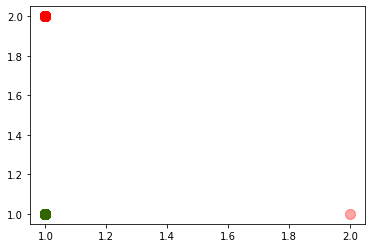

In [109]:
a=d.loc[d['a'] == 1]
b=d.loc[d['a'] == 0]
plt.scatter(a.iloc[:,1],a.iloc[:,3], c = 'g', s =100, alpha=0.1) # 1
plt.scatter(b.iloc[:,1],b.iloc[:,3], c = 'r', s =100, alpha=0.1) # 0

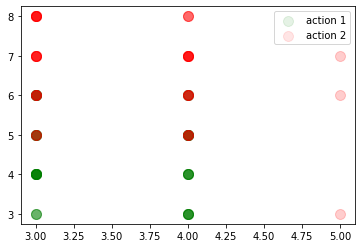

In [112]:
a=d.loc[d['a'] == 1]
b=d.loc[d['a'] == 0]
plt.scatter(a.iloc[:,2],a.iloc[:,4], c = 'g',label = 'action 1', s =100, alpha=0.1) # 1
plt.scatter(b.iloc[:,2],b.iloc[:,4], c = 'r',label = 'action 2', s =100, alpha=0.1) # 0
plt.legend()

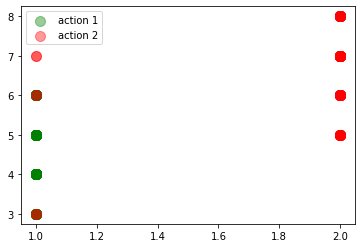

In [114]:
a=d.loc[d['a'] == 1]
b = d.loc[d['a'] == 0]
plt.scatter(a.iloc[:,3],a.iloc[:,4], c = 'g',label = 'action 1', s =100, alpha=0.4) # 1
plt.scatter(b.iloc[:,3],b.iloc[:,4], c = 'r',label = 'action 2', s =100, alpha=0.4) # 1
plt.legend()

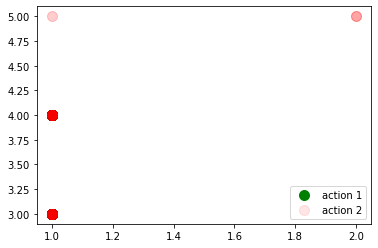

In [126]:
a=d.loc[d['a'] == 1]
b=d.loc[d['a'] == 0]

# plt.scatter(a.iloc[:,1],a.iloc[:,2], c = 'g', s =100, alpha=0.1) # 1
plt.scatter(a.iloc[:,1],a.iloc[:,2], c = 'g',label = 'action 1', s =100, alpha=1) # 1
plt.scatter(b.iloc[:,1],b.iloc[:,2], c = 'r',label = 'action 2', s =100, alpha=0.1) # 1
plt.legend()

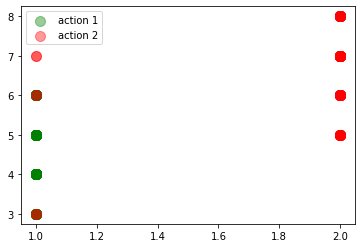

In [130]:
a=d.loc[d['a'] == 1]
b=d.loc[d['a'] == 0]
plt.scatter(a.iloc[:,3],a.iloc[:,4], c = 'g',label = 'action 1', s =100, alpha=0.4) # 1
plt.scatter(b.iloc[:,3],b.iloc[:,4], c = 'r',label = 'action 2', s =100, alpha=0.4) # 1
plt.legend()

In [131]:
# x=d[d['act']==0]
# y=d[d['act']==1]
x=d.iloc[:,1:]

In [132]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(x)

In [133]:
principal_Df = pd.DataFrame(data = pca_data
             , columns = ['principal component 1', 'principal component 2'])

In [134]:
principal_Df

,principal component 1,principal component 2
0,0.619953,0.460729
1,0.619953,0.460729
2,2.559382,0.380064
3,2.559382,0.380064
4,-0.392203,-0.494479
...,...,...
239,0.577511,-0.534811
240,0.619953,0.460729
241,0.619953,0.460729
242,1.547225,-0.575144


In [137]:
a=principal_Df.loc[d['a'] == 1]
b=principal_Df.loc[d['a'] == 0]

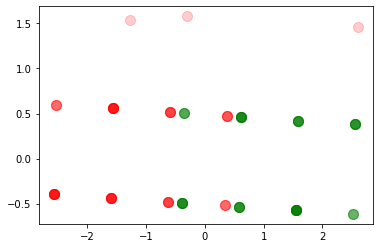

In [138]:
plt.scatter(a.iloc[:,0],a.iloc[:,1], c = 'g', s =100, alpha=0.1) # 1
plt.scatter(b.iloc[:,0],b.iloc[:,1], c = 'r', s =100, alpha=0.1) # 0

<Figure size 432x288 with 0 Axes>

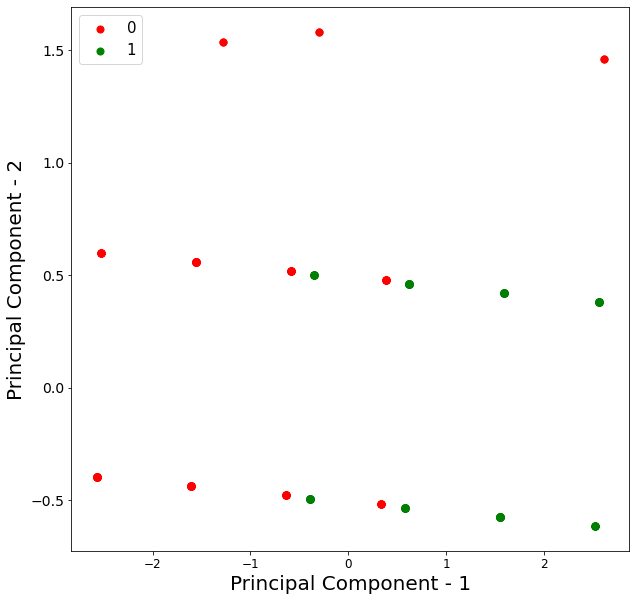

In [139]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
# plt.title("Principal Component Analysis of Breast Cancer Dataset",fontsize=20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = d['a'] == target
    plt.scatter(principal_Df.loc[indicesToKeep, 'principal component 1']
               , principal_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

In [65]:
WITH_FLOW = False
SINGLE_NODE = False # False
OUTPUT_PORT = 2  # 2
W = [0.7, 0.1]
RANDOM_HOP = 0  # 0
RANDOM_CURRENT_DELAY_CC = 0  # originally 0 unit : T
RANDOM_CURRENT_DELAY_BE = [0, 0]  # originally [0,1] unit : T
CC_DEADLINE = 20
BE_DEADLINE = 30
PERIOD_CC = 1
PERIOD_BE = 1
RRW = 10
# MAXSLOTS = 1000
# WEIGHT_FILE = TOPOLOGY_WEIGHTS

sim = GateControlTestSimulation()
result=sim.simulation()

result_folder = [s for s in os.listdir() if s[0]=='@']

for i in result_folder:
    path = './' + i + '/'
    w_list = [f for f in os.listdir(path) if f[0] == '@']
    for w in w_list:
        WEIGHT_FILE = path + w
        sim = GateControlTestSimulation()
        result=sim.simulation()
        print("*****"+w)


reset
SP , Final Step: 1050, success: [40, 0, 0, 0, 0, 0, 0, 40], avg_qdelay: [3.0, 27.0]
RR , Final Step: 1050, success: [40, 2, 0, 0, 0, 0, 2, 40], avg_qdelay: [3.9, 26.1]
DDQN+H , Final Step: 1050, success: [21, 21, 0, 0, 0, 0, 21, 21], avg_qdelay: [9.615000000000002, 20.385]
reset
reset
SP , Final Step: 1050, success: [40, 0, 0, 0, 0, 0, 0, 40], avg_qdelay: [3.0, 27.0]
RR , Final Step: 1050, success: [40, 2, 0, 0, 0, 0, 2, 40], avg_qdelay: [3.9, 26.1]
DDQN+H , Final Step: 1050, success: [40, 2, 0, 0, 0, 0, 2, 40], avg_qdelay: [4.200000000000001, 25.8]
reset
*****@[17279]0.0012507716892287135.h5
reset
SP , Final Step: 1050, success: [40, 0, 0, 0, 0, 0, 0, 40], avg_qdelay: [3.0, 27.0]
RR , Final Step: 1050, success: [40, 2, 0, 0, 0, 0, 2, 40], avg_qdelay: [3.9, 26.1]
DDQN+H , Final Step: 1050, success: [40, 2, 0, 0, 0, 0, 2, 40], avg_qdelay: [4.200000000000001, 25.8]
reset
*****@[17259]0.0013820650056004524.h5
reset
SP , Final Step: 1050, success: [40, 0, 0, 0, 0, 0, 0, 40], avg_qdel